# Remote orthologs (?)

How good is protein structure at finding conserved function? To find out, we tried to compare enzyme function between distantly related species, to see how often function was correctly annotated by structural similarity. In particular, we were interested in cases where orthology via sequence similarity was no longer detectable but the annotated protein function was still similar. Enzymes are an interesting test case, since they have an easily accessible function description (EC number).

The detailed strategy I am going to pursue here:

1. take the proteome of a species distantly related to human (yeast, arabidopsis)
2. foldseek against Alphafold/proteomes
3. keep only significant human hits
4. remove query/target pairs that clearly share evolutionary history (same root orthogroup/same most specific orthogroup)
5. for all remaining cases: only keep enzymes (valid EC is available)
6. calculate how many digits of the EC overlap
7. plot the results


### 1.-2. build proteome, align against all proteomes

```
# download Alphafold proteomes:

> foldseek databases Alphafold/Proteome proteomes tmp/

# download and untar yeast protein structures, then:

> foldseek createdb UP000002311_559292_YEAST_v4/*.pdb.gz yeast
> foldseek search yeast proteomes annot_yeast tmp
> foldseek convertalis yeast proteomes annot_yeast yeast.m8
```

(same for _Arabidopsis_).

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def keep_term(row, term="root"):
    """
    A function to isolate an EggNOG orthogroup by term.
    
    Expects a comma-separated string where the target orthogroup
    contains the term.
    """
    x = np.array(row.split(','))
    keep = np.zeros(len(x), dtype=bool)
    for i, og in enumerate(x):
        keep[i] = term in og
#     print(x, keep)
    try:
        return x[keep][0]
    except IndexError:
        return None

In [3]:
def string_cumsum(x):
    lis = x.split(".")
    res = [lis[0]]
    total = lis[0]
    for x in lis[1:]:
        total = total + "." + x
        res.append(total)
    return np.array(res)

def compare_EC(x, slot1="query_EC", slot2="target_EC"):
    query = [string_cumsum(ec) for ec in x[slot1].split(",")]
    target = [string_cumsum(ec) for ec in x[slot2].split(",")]
    max_agreement = 0
    for q in query:
        for t in target:
            tmp = np.sum(q == t)
            if tmp > max_agreement:
                max_agreement = tmp
    return max_agreement

### 3.-7. keep human hits, remove homologs, subset only enzymes, calculate EC overlap, plot

this is terrible design; all these tasks should be accomplished by different functions. At this point the revision had already dragged on long enough though, and I was going to use this function exactly twice. 

In [4]:
def same_structure_same_EC(query_annot, query_foldseek, target_annot, lowest_relevant_OG="Opisthokonta"):
    in_target = query_foldseek["target"].isin(target_annot["id"])

    best = query_foldseek[in_target].sort_values("e value").drop_duplicates("query")

    informative_columns = ["eggNOG_OGs", "Preferred_name", "EC"]

    best["corrected bit score"] = best["bit score"] / best["alignment length"]

    best = best[["query", "target", "corrected bit score"]]

    query = query_annot.set_index("id").loc[best["query"]][informative_columns]
    query.columns = "query_" + query.columns

    target = target_annot.set_index("id").loc[best["target"]][informative_columns]
    target.columns = "target_" + target.columns

    best = best.reset_index(drop=True).join(target.reset_index(drop=True))

    best = best.join(query, on="query")

    best['query_root'] = best['query_eggNOG_OGs'].apply(keep_term, term="root")
    best['target_root'] = best['target_eggNOG_OGs'].apply(keep_term, term="root")
    best['query_op'] = best['query_eggNOG_OGs'].apply(keep_term, term=lowest_relevant_OG)
    best['target_op'] = best['target_eggNOG_OGs'].apply(keep_term, term=lowest_relevant_OG)

    best["homolog"] = best["query_root"] == best["target_root"]
    best["ortholog"] = best["query_op"] == best["target_op"]

    no_homology_whatsoever = ~best["homolog"] & ~best["ortholog"]
    unrelated = best[no_homology_whatsoever].reset_index(drop=True).copy()

    unrelated["target_EC"].replace("-", None, inplace=True)
    unrelated["query_EC"].replace("-", None, inplace=True)

    target_has_EC = ~unrelated["target_EC"].isnull()
    query_has_EC = ~unrelated["query_EC"].isnull()

    keep = target_has_EC & query_has_EC

    unrelated_with_EC = unrelated[keep].reset_index(drop=True).copy()

    unrelated_with_EC["ec overlap"] = unrelated_with_EC.apply(compare_EC, axis=1)

    fig, ax = plt.subplots()
    b = sns.boxplot(data=unrelated_with_EC, y='corrected bit score', x='ec overlap', ax=ax, fliersize=0, whis=[5, 95])
    counts = unrelated_with_EC.groupby(['ec overlap']).apply(len)
    for i, c in enumerate(counts.values):
        ax.text(i-0.1, 4., str(c), fontsize='x-large')
        ax.set_ylim(0, 5);
        
    return b, best

In [5]:
yeast_annot = pd.read_csv("../data/eggnog/S_cerevisiae_annotations.tsv", sep="\t", skiprows=4, skipfooter=3, engine="python")
yeast_annot["max_annot_lvl"].unique()
yeast_annot["id"] = yeast_annot["#query"].str.split("|").str[1]

yeast_foldseek = pd.read_csv("../data/revision/yeast.m8", sep="\t", header=None)
yeast_foldseek.columns = ["query", "target", "seq. id.", "alignment length", "no. mismatches",
                       "no. gap open", "query start", "query end", "target start", "target end",
                       "e value", "bit score"]
yeast_foldseek["query"] = yeast_foldseek["query"].str.split("-").str[1]
yeast_foldseek["target"] = yeast_foldseek["target"].str.split("-").str[1]

In [6]:
a = yeast_foldseek["query"].unique()
b = yeast_annot["id"].unique()
c = np.intersect1d(a, b)

len(a), len(b), len(c)

(5994, 5537, 5520)

we don't want to get into quibbly territory, so we'll proceed with the IDs that are in both lists and will not wonder why they don't match to 100%.

In [7]:
keep = yeast_annot["id"].isin(c)
yeast_annot = yeast_annot[keep]

keep = yeast_foldseek["query"].isin(c)
yeast_foldseek = yeast_foldseek[keep]

In [8]:
human_annot = pd.read_csv("../data/eggnog/H_sapiens_annotations.tsv", sep="\t", skiprows=4, skipfooter=3, engine="python")
human_annot["id"] = human_annot["#query"].str.split("|").str[1]

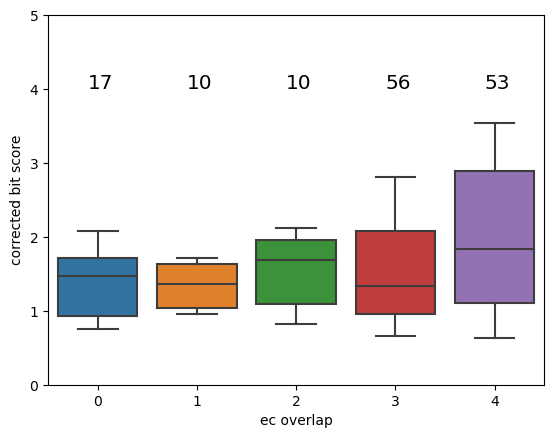

In [9]:
boxplot, table = same_structure_same_EC(yeast_annot, yeast_foldseek, human_annot)
plt.savefig("../data/yeast.svg")
table.to_csv("../data/yeast.tsv", sep="\t")

now repeat for Arabidopsis:

In [10]:
arabidopsis_annot = pd.read_csv("../data/eggnog/A_thaliana_annotations.tsv", sep="\t", skiprows=4, skipfooter=3, engine="python")
arabidopsis_annot["max_annot_lvl"].unique()
arabidopsis_annot["id"] = arabidopsis_annot["#query"].str.split("|").str[1]

arabidopsis_foldseek = pd.read_csv("../data/revision/arabidopsis.m8", sep="\t", header=None)
arabidopsis_foldseek.columns = ["query", "target", "seq. id.", "alignment length", "no. mismatches",
                       "no. gap open", "query start", "query end", "target start", "target end",
                       "e value", "bit score"]
arabidopsis_foldseek["query"] = arabidopsis_foldseek["query"].str.split("-").str[1]
arabidopsis_foldseek["target"] = arabidopsis_foldseek["target"].str.split("-").str[1]

In [11]:
a = arabidopsis_foldseek["query"].unique()
b = arabidopsis_annot["id"].unique()
c = np.intersect1d(a, b)

len(a), len(b), len(c)

(27298, 25145, 25071)

(same disclaimer about quibbly territory)

In [12]:
keep = arabidopsis_annot["id"].isin(c)
arabidopsis_annot = arabidopsis_annot[keep]

keep = arabidopsis_foldseek["query"].isin(c)
arabidopsis_foldseek = arabidopsis_foldseek[keep]

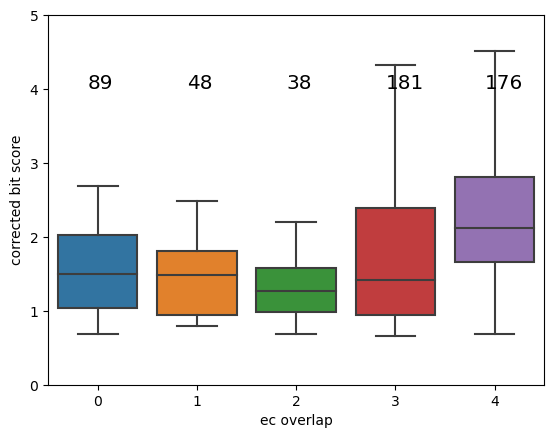

In [13]:
boxplot, table = same_structure_same_EC(arabidopsis_annot, arabidopsis_foldseek, human_annot, lowest_relevant_OG="Eukaryota")
plt.savefig("../data/arabidopsis.svg")
table.to_csv("../data/arabidopsis.tsv", sep="\t")